# Data Visualization

In [1]:
import pandas as pd 
import numpy as np 
scallop = pd.read_csv("scallop.csv", usecols = ["latitude", "longitude","tot.catch"])
scallop.head()

,latitude,longitude,tot.catch
0,40.55000,-71.55000,0
1,40.46667,-71.51667,0
2,40.51667,-71.71667,0
3,40.38333,-71.85000,1
4,40.31667,-71.78333,0


(array([127.,   7.,   6.,   2.,   0.,   1.,   0.,   2.,   0.,   1.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([   0. ,  354.2,  708.4, 1062.6, 1416.8, 1771. , 2125.2, 2479.4,
        2833.6, 3187.8, 3542. , 3896.2, 4250.4, 4604.6, 4958.8, 5313. ,
        5667.2, 6021.4, 6375.6, 6729.8, 7084. ]),
 <a list of 20 Patch objects>)

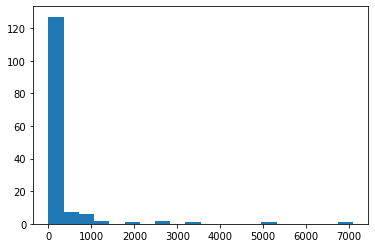

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(scallop["tot.catch"], bins = 20)

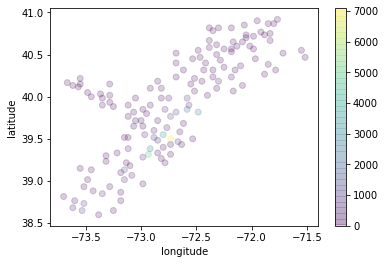

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(scallop["longitude"], scallop["latitude"], alpha=0.2,
            c=scallop["tot.catch"], cmap='viridis')
plt.colorbar()
plt.xlabel("longitude")
plt.ylabel("latitude");

The data seems left skewed and obey the normal assumption of the Gaussian Process.

(array([21.,  4.,  1.,  6.,  7.,  6., 16., 17., 15., 10.,  9.,  4.,  8.,
         8.,  4.,  4.,  2.,  3.,  1.,  2.]),
 array([0.        , 0.44328676, 0.88657352, 1.32986027, 1.77314703,
        2.21643379, 2.65972055, 3.1030073 , 3.54629406, 3.98958082,
        4.43286758, 4.87615433, 5.31944109, 5.76272785, 6.20601461,
        6.64930136, 7.09258812, 7.53587488, 7.97916164, 8.42244839,
        8.86573515]),
 <a list of 20 Patch objects>)

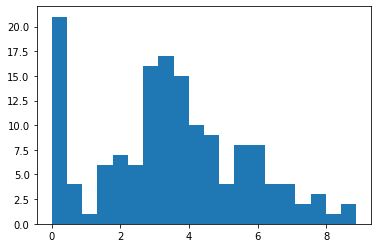

In [4]:
plt.hist(np.log(scallop["tot.catch"]+1), bins = 20)

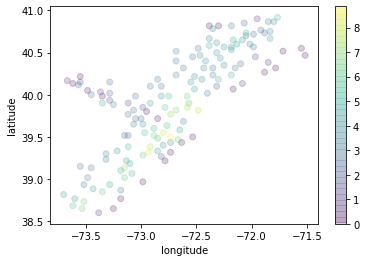

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(scallop["longitude"], scallop["latitude"], alpha=0.2,
            c=np.log(scallop["tot.catch"]+1), cmap='viridis')
plt.colorbar()
plt.xlabel("longitude")
plt.ylabel("latitude");

log + 1 transformation

In [5]:
data = scallop
data["tot.catch"] = np.log(scallop["tot.catch"] + 1)

# Split the training data and testing data

Pay attention to how the data split. Thinking about time series, we may care more about the part that does not have the observations. Therefore, block the data or flip the data might be a good way to think about being a test data set.  


In [12]:
# choose longitude more than -72 as testing data
train = data[data["longitude"]< -72]
test = data[data["longitude"]>= -72]

# Gaussian Process

## Kernel
define Kernel Squared Exponential (SE) as equation 2.16 in the text book:\
$kernel\_SE = \sigma_f^2 exp(-\frac{1}{2l^2}|x_i - x_j|^2)$

In [20]:
def kernel_SE(X1, X2):
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return np.exp(-0.5 * sqdist)

## Gaussian process regression

Using the equation given by text book:\
$mean = K(X_s,X)[K(X,X) + \sigma^2 *I]^{-1}y$\
$cov = K(X_s,X_s) - K(X_s,X)[K(X,X) + \sigma^2 *I]^{-1} K(X,X_s)$\

When considering the prior of f, we use 0 mean since we believe most area have no scallop. Don't use observations' mean, since the prior should independent with the obs.

In [18]:
from numpy.linalg import inv
def posterior_predictive(kernel, X_s, X_train, Y_train, sigma_y=1e-8):
    K = kernel(X_train, X_train) + sigma_y**2 * np.eye(len(X_train))
    K_s_ = kernel(X_s, X_train)
    K__s = kernel(X_train, X_s)
    K_ss = kernel(X_s, X_s)
    K_inv = inv(K)
    
    # Equation (4)
    mu_s = K_s_.dot(K_inv).dot(Y_train)

    # Equation (5)
    cov_s = K_ss - K_s_.dot(K_inv).dot(K__s)
    
    marginal_log_f = -1/2 
    return mu_s, cov_s

Using the alg in the 2.1:
1. $L = cholesky(K)$
2. $\alpha = L^T/(L/y)$
3. $f_\star = k_\star^T\alpha$\
   $v = L/k_\star$
4. $V[f_\star]:=k(_\star,x_\star)−v^Tv$
5. $logp(y|X) = -\frac{1}{2}y^T\alpha - \sum log(L_{ii}) - \frac{n}{2}log(2\pi)$

return $f_\star, V[f_\star], logp(y|X)$

In [28]:
def posterior_predictive_stable(kernel, X_s, X_train, Y_train, sigma_y=1e-8):
    K = kernel(X_train, X_train) + sigma_y**2 * np.eye(len(X_train))
    L = cholesky(K)
    alpha = lstsq(L.T, lstsq(L, Y_train)[0])[0]
    
    K__s = kernel(X_train, X_s)
    f_s = K__s.T.dot(alpha)
    
    v = lstsq(L,K__s)[0]
    K_ss = kernel(X_s, X_s)
    cov_s = K_ss - v.T.dot(v)
    
    marginal_log_f = -1/2 * Y_train.T.dot(alpha) - np.sum(np.log(np.diagonal(L))) - len(Y_train)/2*np.log(2*np.pi)
    return mu_s, cov_s, marginal_log_f

It is easier to visualize in 2D plot.

In [73]:
def plot_gp_2D(gx, gy, mu,cov, X_train, Y_train, X_test, Y_test):
    z_min = min(min(mu), min(Y_train))
    z_max = max(max(mu), max(Y_train))
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    c = ax1.pcolormesh(gx, gy,mu_s.reshape(gx.shape), vmin = z_min,vmax = z_max, alpha=0.2,cmap='viridis')
    ax1.scatter(X_train[:,0], X_train[:,1], alpha=0.5, c=Y_train, vmin = z_min,vmax = z_max,cmap='viridis')
    ax1.scatter(X_test[:,0], X_test[:,1], marker='x', alpha=0.5, c=Y_test, cmap='viridis')
    fig.colorbar(c, ax = ax1)
    ax1.set_xlabel("longitude")
    ax1.set_ylabel("latitude")
    ax1.set_title("Posterior mean")
    
    
    
    c = ax2.pcolormesh(gx, gy, np.diag(cov).reshape(gx.shape), alpha=0.2, cmap='viridis')
    fig.colorbar(c, ax = ax2)
    ax2.set_xlabel("longitude")
    ax2.set_ylabel("latitude")
    ax2.set_title("Posterior variance")
    

In [66]:
def plot_gp_3D(gx, gy, mu,cov, X_train, Y_train):
    
    plt.figure(figsize=(12,7))
    ax = plt.gcf().add_subplot(1, 2, 1, projection='3d')
    ax.plot_surface(gx, gy, mu.reshape(gx.shape), cmap=cm.coolwarm, linewidth=0, alpha=0.2, antialiased=False)
    ax.scatter(X_train[:,0], X_train[:,1], Y_train, c=Y_train, cmap='viridis')
    ax.set_title("Posterior mean")
    ax = plt.gcf().add_subplot(1, 2, 2, projection='3d')
    ax.plot_surface(gx, gy, np.diag(cov).reshape(gx.shape), cmap='viridis', linewidth=0, alpha=0.2, antialiased=False)
    ax.set_title("Posterior variance")
    

## Prediction using Noisy Observations


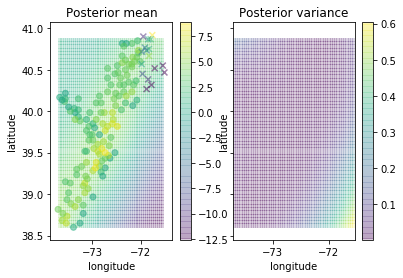

In [95]:
# from gaussian_processes_util import plot_gp_2D
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


noise_2D =0.2

rx = np.arange(min(data["longitude"]), max(data["longitude"]), 0.04)
ry = np.arange(min(data["latitude"]), max(data["latitude"]), 0.04)
gx, gy = np.meshgrid(rx, ry)


X_2D = np.c_[gx.ravel(), gy.ravel()]

X_2D_train = np.c_[train["longitude"],  train["latitude"]]
Y_2D_train = np.array(train["tot.catch"])

X_2D_test = np.c_[test["longitude"],  test["latitude"]]
Y_2D_test = np.array(test["tot.catch"])

mu_s, cov_s = posterior_predictive(kernel_SE, X_2D, X_2D_train, Y_2D_train, sigma_y=noise_2D)
plot_gp_2D(gx, gy, mu_s, cov_s,X_2D_train, Y_2D_train, X_2D_test, Y_2D_test)

## Model validation

### whether mu_s_test fall into the confident interval

In [96]:
mu_s_test, cov_s_test = posterior_predictive(kernel_SE, X_2D_test, X_2D_train, Y_2D_train, sigma_y=noise_2D)

2.6260331968007344

In [97]:
pd.DataFrame({"pred":mu_s_test,
              "true":Y_2D_test,
              "lower": mu_s_test - 1.96 * np.sqrt(np.diag(cov_s_test)),
              "upper": mu_s_test + 1.96 * np.sqrt(np.diag(cov_s_test))})

,pred,true,lower,upper
0,1.859826,0.000000,1.297331,2.422321
1,1.126391,0.000000,0.515954,1.736829
2,2.455480,0.000000,2.076737,2.834223
3,2.482468,0.693147,2.210816,2.754120
4,1.718251,0.000000,1.373216,2.063285
5,2.100174,0.000000,1.830933,2.369414
6,3.515451,5.697093,3.123306,3.907596
7,3.523138,3.850148,3.181148,3.865127
8,3.523879,3.178054,3.222796,3.824962
9,3.405795,0.693147,3.157293,3.654296


### RMSE
turn back to original scale

In [98]:
 np.sqrt(np.mean((np.exp(mu_s_test) - np.exp(Y_2D_test))**2))

69.13349704041428